# Introduction to GPT-4o and GPT-4o mini

GPT-4o ("o" for "omni") and GPT-4o mini are natively multimodal models designed to handle a combination of text, audio, and video inputs, and can generate outputs in text, audio, and image formats. GPT-4o mini is the lightweight version of GPT-4o.

### Background

Before GPT-4o, users could interact with ChatGPT using Voice Mode, which operated with three separate models. GPT-4o integrates these capabilities into a single model that's trained across text, vision, and audio. This unified approach ensures that all inputs — whether text, visual, or auditory — are processed cohesively by the same neural network.

GPT-4o mini is the next iteration of this omni model family, available in a smaller and cheaper version. This model offers higher accuracy than GPT-3.5 Turbo while being just as fast and supporting multimodal inputs and outputs.

### Current API Capabilities

Currently, the `gpt-4o-mini` model supports `{text, image}`, with `{text}` outputs, the same modalities as `gpt-4-turbo`.  As a preview, we will also be using the `gpt-4o-audio-preview` model to showcase transcription though the GPT4o model.

## Getting Started

### Install OpenAI SDK for Python



In [ ]:
%pip install --upgrade openai

### Configure the OpenAI client and submit a test request
To setup the client for our use, we need to create an API key to use with our request. Skip these steps if you already have an API key for usage. 

You can get an API key by following these steps:
1. [Create a new project](https://help.openai.com/en/articles/9186755-managing-your-work-in-the-api-platform-with-projects)
2. [Generate an API key in your project](https://platform.openai.com/api-keys)
3. (RECOMMENDED, BUT NOT REQUIRED) [Setup your API key for all projects as an env var](https://platform.openai.com/docs/quickstart/step-2-set-up-your-api-key)

Once we have this setup, let's start with a simple {text} input to the model for our first request. We'll use both `system` and `user` messages for our first request, and we'll receive a response from the `assistant` role.

In [2]:
from openai import OpenAI 
import os

## Set the API key and model name
MODEL="gpt-4o-mini"
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as an env var>"))

In [3]:
completion = client.chat.completions.create(
  model=MODEL,
  messages=[
    {"role": "system", "content": "You are a helpful assistant. Help me with my math homework!"}, # <-- This is the system message that provides context to the model
    {"role": "user", "content": "Hello! Could you solve 2+2?"}  # <-- This is the user message for which the model will generate a response
  ]
)

print("Assistant: " + completion.choices[0].message.content)

Assistant: Sure! \(2 + 2 = 4\).


## Image Processing
GPT-4o mini can directly process images and take intelligent actions based on the image. We can provide images in two formats:
1. Base64 Encoded
2. URL

Let's first view the image we'll use, then try sending this image as both Base64 and as a URL link to the API

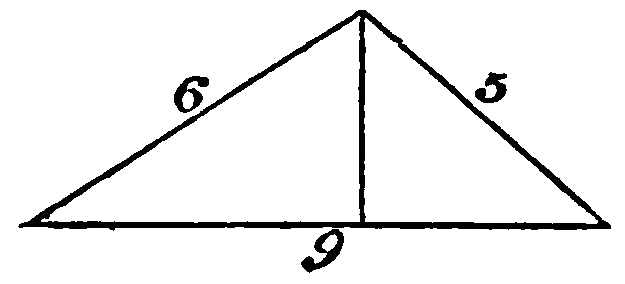

In [4]:
from IPython.display import Image, display, Audio, Markdown
import base64

IMAGE_PATH = "data/triangle.png"

# Preview image for context
display(Image(IMAGE_PATH))

#### Base64 Image Processing

In [5]:
# Open the image file and encode it as a base64 string
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

base64_image = encode_image(IMAGE_PATH)

response = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": "You are a helpful assistant that responds in Markdown. Help me with my math homework!"},
        {"role": "user", "content": [
            {"type": "text", "text": "What's the area of the triangle?"},
            {"type": "image_url", "image_url": {
                "url": f"data:image/png;base64,{base64_image}"}
            }
        ]}
    ],
    temperature=0,
)

print(response.choices[0].message.content)

To find the area of the triangle, you can use the formula:

\[
\text{Area} = \frac{1}{2} \times \text{base} \times \text{height}
\]

In the triangle you provided:

- The base is \(9\) (the length at the bottom).
- The height is \(5\) (the vertical line from the top vertex to the base).

Now, plug in the values:

\[
\text{Area} = \frac{1}{2} \times 9 \times 5
\]

Calculating this gives:

\[
\text{Area} = \frac{1}{2} \times 45 = 22.5
\]

Thus, the area of the triangle is **22.5 square units**.


#### URL Image Processing

In [6]:
response = client.chat.completions.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": "You are a helpful assistant that responds in Markdown. Help me with my math homework!"},
        {"role": "user", "content": [
            {"type": "text", "text": "What's the area of the triangle?"},
            {"type": "image_url", "image_url": {
                "url": "https://upload.wikimedia.org/wikipedia/commons/e/e2/The_Algebra_of_Mohammed_Ben_Musa_-_page_82b.png"}
            }
        ]}
    ],
    temperature=0,
)

print(response.choices[0].message.content)

To find the area of the triangle, you can use the formula:

\[
\text{Area} = \frac{1}{2} \times \text{base} \times \text{height}
\]

In the triangle you provided:

- The base is \(9\) (the length at the bottom).
- The height is \(5\) (the vertical line from the top vertex to the base).

Now, plug in the values:

\[
\text{Area} = \frac{1}{2} \times 9 \times 5
\]

Calculating this gives:

\[
\text{Area} = \frac{1}{2} \times 45 = 22.5
\]

Thus, the area of the triangle is **22.5 square units**.


## Video Processing
While it's not possible to directly send a video to the API, GPT-4o can understand videos if you sample frames and then provide them as images. 

Since `gpt-4o-mini` does not yet support audio-in (as of Nov 2024), we'll use a combination of `gpt-4o-mini` and `gpt-4o-audio-preview` to process both the audio and visual for a provided video, and showcase two usecases:
1. Summarization
2. Question and Answering



### Setup for Video Processing
We'll use two python packages for video processing - opencv-python and moviepy. 

These require [ffmpeg](https://ffmpeg.org/about.html), so make sure to install this beforehand. Depending on your OS, you may need to run `brew install ffmpeg` or `sudo apt install ffmpeg`

In [ ]:
%pip install opencv-python
%pip install moviepy

### Process the video into two components: frames and audio

In [8]:
import cv2
from moviepy import *
import time
import base64

# We'll be using the OpenAI DevDay Keynote Recap video. You can review the video here: https://www.youtube.com/watch?v=h02ti0Bl6zk
VIDEO_PATH = "data/keynote_recap.mp4"

In [9]:
def process_video(video_path, seconds_per_frame=2):
    base64Frames = []
    base_video_path, _ = os.path.splitext(video_path)

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)
    curr_frame=0

    # Loop through the video and extract frames at specified sampling rate
    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()

    # Extract audio from video
    audio_path = f"{base_video_path}.mp3"
    clip = VideoFileClip(video_path)
    clip.audio.write_audiofile(audio_path, bitrate="32k")
    clip.audio.close()
    clip.close()

    print(f"Extracted {len(base64Frames)} frames")
    print(f"Extracted audio to {audio_path}")
    return base64Frames, audio_path

# Extract 1 frame per second. You can adjust the `seconds_per_frame` parameter to change the sampling rate
base64Frames, audio_path = process_video(VIDEO_PATH, seconds_per_frame=1)


MoviePy - Writing audio in data/keynote_recap.mp3


MoviePy - Done.
Extracted 218 frames
Extracted audio to data/keynote_recap.mp3


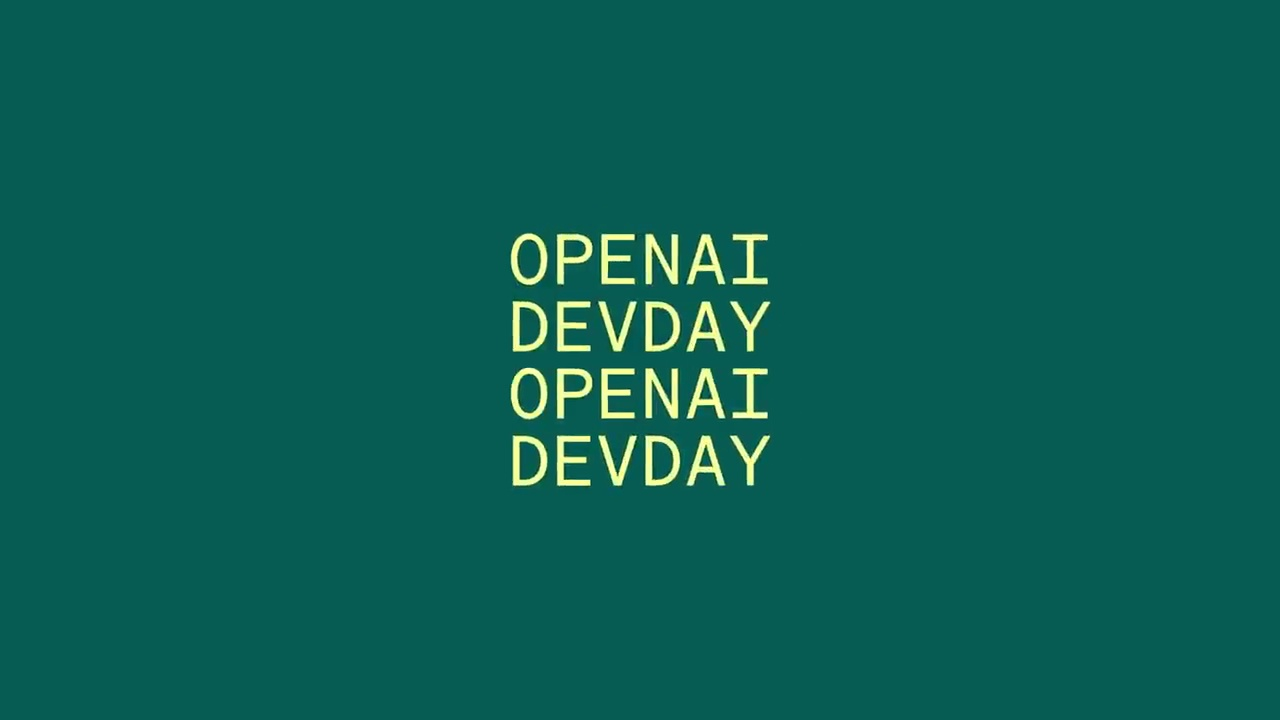

In [10]:
## Display the frames and audio for context
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
    time.sleep(0.025)

Audio(audio_path)

### Example 1: Summarization
Now that we have both the video frames and the audio, let's run a few different tests to generate a video summary to compare the results of using the models with different modalities. We should expect to see that the summary generated with context from both visual and audio inputs will be the most accurate, as the model is able to use the entire context from the video.

1. Visual Summary
2. Audio Summary
3. Visual + Audio Summary

#### Visual Summary
The visual summary is generated by sending the model only the frames from the video. With just the frames, the model is likely to capture the visual aspects, but will miss any details discussed by the speaker.

In [11]:
response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content": "You are generating a video summary. Please provide a summary of the video. Respond in Markdown."},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url", 
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames)
        ],
    }
    ],
    temperature=0,
)
print(response.choices[0].message.content)

# OpenAI Dev Day Summary

## Overview
The video captures highlights from OpenAI's Dev Day, showcasing new advancements and features in AI technology, particularly focusing on the latest developments in the GPT-4 model and other tools.

## Key Highlights

### Event Introduction
- The event is branded as "OpenAI Dev Day," featuring a modern and engaging visual presentation.

### Keynote Recap
- The keynote session includes a recap of significant updates and innovations in AI, emphasizing the importance of community and developer engagement.

### New Features
- **GPT-4 Turbo**: Introduction of a more efficient version of GPT-4, promising faster processing and improved performance.
- **DALL-E 3**: Updates on the image generation model, enhancing creative capabilities.
- **Custom Models**: Introduction of features allowing developers to create tailored AI models for specific applications.

### Technical Innovations
- **Function Calling**: Demonstration of how the new function calling featur

The results are as expected - the model is able to capture the high level aspects of the video visuals, but misses the details provided in the speech.

#### Audio Summary
The audio summary is generated by sending the model the audio transcript. With just the audio, the model is likely to bias towards the audio content, and will miss the context provided by the presentations and visuals.

`{audio}` input for GPT-4o is currenlty in preview, but will be incorporated into the base model in the near future.  Because of this, we will use the `gpt-4o-audio-preview` model to process the audio.

In [12]:
with open(audio_path, 'rb') as audio_file:
    audio_content = base64.b64encode(audio_file.read()).decode('utf-8')

response = client.chat.completions.create(
            model='gpt-4o-audio-preview',
            modalities=["text"],
            messages=[
                    {   "role": "system", 
                        "content":"You are generating a transcript. Create a transcript of the provided audio."
                    },
                    {
                        "role": "user",
                        "content": [
                            { 
                                "type": "text",
                                "text": "this is the audio."
                            },
                            {
                                "type": "input_audio",
                                "input_audio": {
                                    "data": audio_content,
                                    "format": "mp3"
                                }
                            }
                        ]
                    },
                ],
            temperature=0,
        )

# Extract and return the transcription
transcription = response.choices[0].message.content
print (transcription)

Welcome to our first ever OpenAI DevDay. Today, we are launching a new model, GPT-4 Turbo. GPT-4 Turbo supports up to 128,000 tokens of context. We have a new feature called JSON mode, which ensures the model will respond with valid JSON. You can now call many functions at once, and it'll do better at following instructions in general. You want these models to be able to access better knowledge about the world, so do we. So we're launching retrieval in the platform. You can bring knowledge from outside documents or databases into whatever you're building. GPT-4 Turbo has knowledge about the world up to April of 2023, and we will continue to improve that over time. DALL-E 3, GPT-4 Turbo with vision, and the new text-to-speech model are all going into the API today. Today, we're launching a new program called Custom Models. With Custom Models, our researchers will work closely with a company to help them make a great custom model, especially for them and their use case using our tools. H

Looking good.  Now let's summarize this and format in markdown.

In [13]:
response = client.chat.completions.create(
            model=MODEL,
            modalities=["text"],
            messages=[
                {"role": "system", "content": "You are generating a transcript summary. Create a summary of the provided transcription. Respond in Markdown."},
                {"role": "user", "content": f"Summarize this text: {transcription}"},
            ],
            temperature=0,
        )
transcription_summary = response.choices[0].message.content
print (transcription_summary)

# Summary of OpenAI DevDay Announcement

Welcome to the inaugural OpenAI DevDay, where several exciting updates were announced:

- **Launch of GPT-4 Turbo**: This new model supports up to 128,000 tokens of context and features a new JSON mode for valid JSON responses. It can now handle multiple function calls simultaneously and has improved instruction-following capabilities.

- **Knowledge Retrieval**: A new retrieval feature allows models to access external documents and databases, enhancing their knowledge base, which is current up to April 2023.

- **DALL-E 3 and New Models**: DALL-E 3, GPT-4 Turbo with vision, and a new text-to-speech model are now available in the API.

- **Custom Models Program**: OpenAI will collaborate with companies to create tailored models suited to their specific needs.

- **Increased Rate Limits**: Established GPT-4 customers will see a doubling of tokens per minute, with options to request further changes in their API settings.

- **Cost Efficiency**: GP

The audio summary is biased towards the content discussed during the speech, but comes out with much less structure than the video summary.

#### Audio + Visual Summary
The Audio + Visual summary is generated by sending the model both the visual and the audio from the video at once. When sending both of these, the model is expected to better summarize since it can perceive the entire video at once.

In [14]:
## Generate a summary with visual and audio
response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content":"""You are generating a video summary. Create a summary of the provided video and its transcript. Respond in Markdown"""},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url", 
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames),
        {"type": "text", "text": f"The audio transcription is: {transcription}"}
        ],
    }
],
    temperature=0,
)
print(response.choices[0].message.content)

# OpenAI DevDay Summary

## Overview
The first-ever OpenAI DevDay introduced significant advancements in AI technology, particularly focusing on the launch of **GPT-4 Turbo** and various new features aimed at enhancing user experience and capabilities.

## Key Announcements

### 1. **GPT-4 Turbo**
- **Token Capacity**: Supports up to **128,000 tokens** of context.
- **JSON Mode**: A new feature ensuring responses are in valid JSON format.
- **Function Calling**: Enhanced ability to call multiple functions simultaneously and improved adherence to instructions.

### 2. **Knowledge Retrieval**
- Introduction of **retrieval capabilities** allowing models to access external documents and databases, enhancing their knowledge base.

### 3. **DALL-E 3 and Vision Models**
- Launch of **DALL-E 3**, **GPT-4 Turbo with vision**, and a new **text-to-speech model** available in the API.

### 4. **Custom Models Program**
- A new initiative where OpenAI researchers collaborate with companies to create

After combining both the video and audio, we're able to get a much more detailed and comprehensive summary for the event which uses information from both the visual and audio elements from the video.

### Example 2: Question and Answering
For the Q&A, we'll use the same concept as before to ask questions of our processed video while running the same 3 tests to demonstrate the benefit of combining input modalities:
1. Visual Q&A
2. Audio Q&A
3. Visual + Audio Q&A 

In [15]:
QUESTION = "Question: Why did Sam Altman have an example about raising windows and turning the radio on?"

In [16]:
qa_visual_response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content": "Use the video to answer the provided question. Respond in Markdown."},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url", "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames),
        QUESTION
        ],
    }
    ],
    temperature=0,
)
print("Visual QA:\n" + qa_visual_response.choices[0].message.content)

Visual QA:
Sam Altman used the example of raising windows and turning the radio on to illustrate the concept of function calling in AI. This example demonstrates how AI can interpret natural language commands and translate them into specific function calls, enhancing the interaction between users and AI systems. By showing a relatable scenario, he highlighted the AI's ability to understand and execute multiple tasks based on user instructions, showcasing advancements in AI capabilities.


In [17]:
qa_audio_response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content":"""Use the transcription to answer the provided question. Respond in Markdown."""},
    {"role": "user", "content": f"The audio transcription is: {transcription}. \n\n {QUESTION}"},
    ],
    temperature=0,
)
print("Audio QA:\n" + qa_audio_response.choices[0].message.content)

Audio QA:
The transcription provided does not include any mention of Sam Altman discussing raising windows or turning the radio on. Therefore, I cannot provide an answer to that specific question based on the given text. If you have more context or another transcription that includes that example, please share it, and I would be happy to help!


In [18]:
qa_both_response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content":"""Use the video and transcription to answer the provided question."""},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url", 
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames),
                        {"type": "text", "text": f"The audio transcription is: {transcription}"},
        QUESTION
        ],
    }
    ],
    temperature=0,
)
print("Both QA:\n" + qa_both_response.choices[0].message.content)

Both QA:
Sam Altman used the example of raising windows and turning the radio on to illustrate the new function calling capabilities of the GPT-4 Turbo model. This example demonstrates how the model can interpret and execute multiple commands in a more natural way, allowing users to interact with it using everyday language. By showing how the model can break down a complex request into specific functions, he highlighted the improved understanding and functionality of the model in handling real-world tasks.


Comparing the three answers, the most accurate answer is generated by using both the audio and visual from the video. Sam Altman did not discuss the raising windows or radio on during the Keynote, but referenced an improved capability for the model to execute multiple functions in a single request while the examples were shown behind him.

## Conclusion

Integrating many input modalities such as audio, visual, and textual, significantly enhances the performance of the model on a diverse range of tasks. This multimodal approach allows for more comprehensive understanding and interaction, mirroring more closely how humans perceive and process information. 

Currently, GPT-4o and GPT-4o mini in the API support text and image inputs, with audio capabilities coming soon.  For the time being, use the `gpt-4o-audio-preview` for audio inputs.